In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1: Inital steps

### Step 1.1: Install required libraries

In [ ]:
!pip install -q torch torchvision
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00


### Step 1.2: Import required libraries

In [ ]:
import torch
from datasets import load_dataset
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
import numpy as np
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from nltk.corpus import stopwords
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Step 1.3: Load dataset from huggingface using load_dataset method from Datasets library

In [ ]:
dataset_train = load_dataset('lex_glue', 'ecthr_b', split = 'train')
dataset_validation = load_dataset('lex_glue', 'ecthr_b', split = 'validation')
dataset_test = load_dataset('lex_glue', 'ecthr_b', split = 'test')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/9000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

### Step 1.4: Convert into pandas dataframes for easier processing

In [ ]:
df_train = pd.DataFrame(dataset_train)
df_validation = pd.DataFrame(dataset_validation)
df_test = pd.DataFrame(dataset_test)

# Dataset description
We are using __ecthr_b__ dataset from the Lex GLUE collection, is designed for the task of classifying legal documents tailored for the European Court of Human Rights (ECHR).

### Features \& Labels
In the dataset specified above, we have just two features -
1. text:

> This feature consists of textutal content of the legal document, which is list of factual paragraphs (facts) from the case description.

2. labels:

> This feature is a list of numbers representing articles of ECHR that were allegedly violated (considered by the court) by the case specified in the document.

Sample data:

In [ ]:
df_train.head()

,text,labels
0,[11. At the beginning of the events relevant ...,[4]
1,[9. The applicant is the monarch of Liechtens...,"[8, 3, 9]"
2,[9. In June 1949 plots of agricultural land o...,[3]
3,"[8. In 1991 Mr Dušan Slobodník, a research wo...","[6, 8, 5]"
4,"[9. The applicant is an Italian citizen, born...","[8, 3]"


In [ ]:
df_validation.head()

,text,labels
0,[5. The applicant was born in 1983 and is det...,[4]
1,[5. The applicant was born in 1982 and is cur...,[1]
2,[5. The applicant was born in 1955 and lives ...,"[1, 3]"
3,[6. The applicant was born in 1977 and lives ...,[]
4,[6. The applicants were born in 1983 and 2007...,"[7, 2, 3, 4]"


In [ ]:
df_test.head()

,text,labels
0,"[5. The applicant is a journalist for DN.no, ...",[6]
1,[5. The applicant was born in 1940 and lives ...,[4]
2,[5. The applicant was born in 1965 and lives ...,[3]
3,[5. The applicant was born in 1967 and lives ...,[3]
4,[5. The applicant was born in 1967 and lives ...,"[1, 3]"


## Step 2: Pre-processing
Data pre-processing is technique of preparing (cleaning and organizing) data to make it suitable for training and using Machine Learning models.

### Step 2.1: Remove duplicates and missing data

In [ ]:
df_train = df_train.drop_duplicates(subset = ['text']).dropna().reset_index(drop = True)
df_validation = df_validation.drop_duplicates(subset = ['text']).dropna().reset_index(drop = True)
df_test = df_test.drop_duplicates(subset = ['text']).dropna().reset_index(drop = True)

### Step 2.2: Combine paragraphs to get complete document

In [ ]:
df_train['text_combined'] = df_train['text'].apply(lambda paragraphs: ' '.join(paragraphs))
df_validation['text_combined'] = df_validation['text'].apply(lambda paragraphs: ' '.join(paragraphs))
df_test['text_combined'] = df_test['text'].apply(lambda paragraphs: ' '.join(paragraphs))

### Step 2.3: Lowercase, remove numbers, remove special characters and non-english words

In [ ]:
nltk.download('stopwords')
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    text = re.sub(r'<num>', '', text)
    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    processed_text = ' '.join(filtered_words)
    return processed_text

df_train['text_combined'] = df_train['text_combined'].apply(preprocess_text)
df_validation['text_combined'] = df_validation['text_combined'].apply(preprocess_text)
df_test['text_combined'] = df_test['text_combined'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Step 3: Data exploration and analysis


### Step 3.1: Class distribution: Visualise and check distribution of classes

Class distribution analysis helps you identify if your dataset is balanced or skewed towards certain classes. Imbalanced classes can affect the performance of machine learning models,

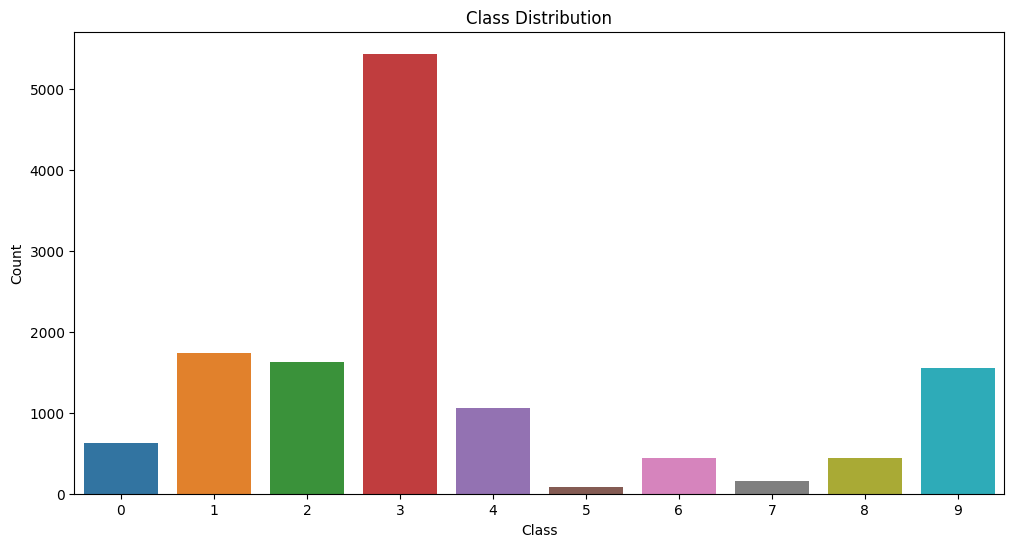

In [ ]:
class_distribution = df_train['labels'].explode().value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x = class_distribution.index, y = class_distribution.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

We can observe that in the data some classes occurred a lot more than others. For example class 3 occurred much more than any other.

### Step 3.2: Visualise text length
We have limited time and computation resources, so we can utilise this distribution to make decisions while deciding on models, sequence lengths etc.

Here, we can see most sentences are between length 0-1500, hence as a trade-off between compute, time and accuracy, I decided to go with sequence length of 1500 while finetuning the model.

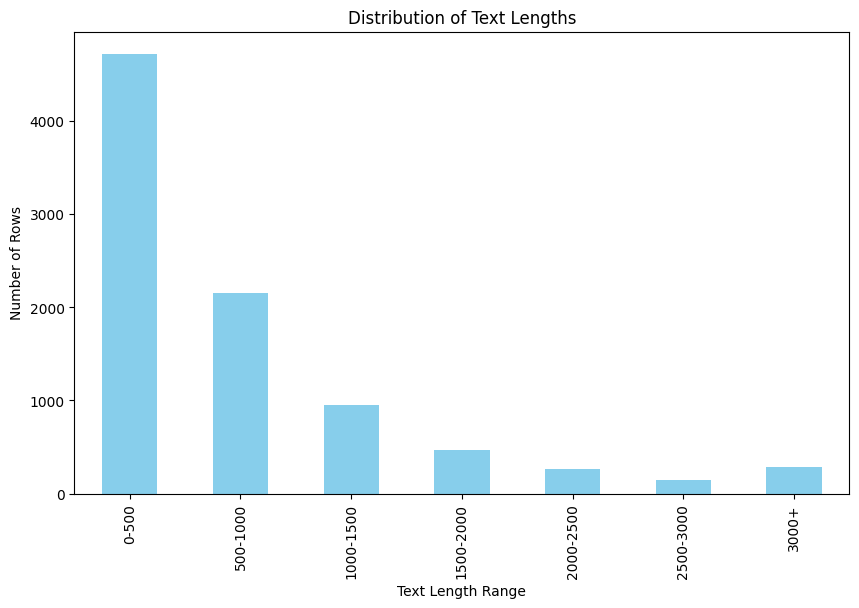

In [ ]:
df_train['text_length'] = df_train['text_combined'].apply(lambda x: len(x.split()))

bins = [0, 500, 1000, 1500, 2000, 2500, 3000, float('inf')]
labels = ['0-500', '500-1000', '1000-1500', '1500-2000', '2000-2500', '2500-3000', '3000+']

df_train['text_length_range'] = pd.cut(df_train['text_length'], bins = bins, labels = labels, right = False)

# Plot
plt.figure(figsize=(10, 6))
df_train['text_length_range'].value_counts().sort_index().plot(kind = 'bar', color = 'skyblue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length Range')
plt.ylabel('Number of Rows')
plt.show()


Document text are huge. Document length range from few hundreds to 5000+. Average length of the text is around 1000 - 1500 after removal of stop words.

### Step 3.3: Visualising word cloud
This is just to observe common words in the text and maybe infer some relations before training the model.

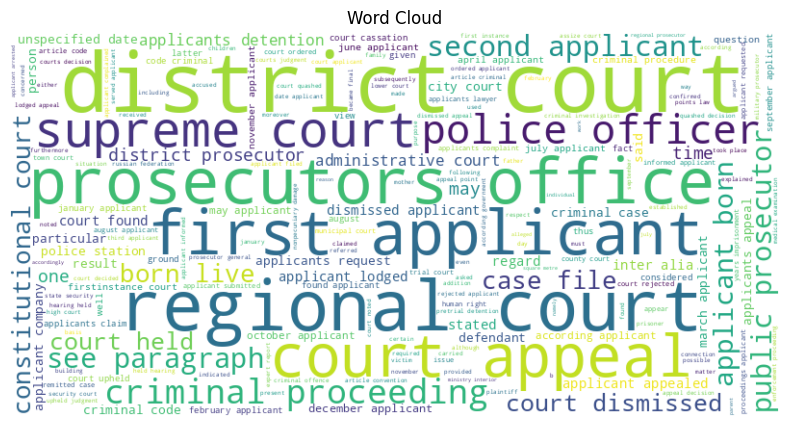

In [ ]:
wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(' '.join(df_train['text_combined']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

## Step 4: Using BERT

Bidirectional Encoder Representations from Transformers (BERT) is a language model based on the transformer architecture. We utilise the BERT pretrained on ECHR legal cases for better performance.

### Step 4.1: Tokenize sentences using BERT tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('nlpaueb/bert-base-uncased-echr')
maxi_length = 1500
# Tokenize, truncate and pad sequences to a maximum length
train_encodings = tokenizer(list(df_train["text_combined"]), padding = True, return_tensors = 'pt', max_length = maxi_length, truncation = True)
validation_encodings = tokenizer(list(df_validation["text_combined"]), padding = True, return_tensors = 'pt', max_length = maxi_length, truncation = True)
test_encodings = tokenizer(list(df_test["text_combined"]), padding = True, return_tensors = 'pt', max_length = maxi_length, truncation = True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

In [ ]:
# Convert labels to binary format
mlb = MultiLabelBinarizer()
train_labels_binary = mlb.fit_transform(df_train["labels"])
validation_labels_binary = mlb.fit_transform(df_validation["labels"])
test_labels_binary = mlb.transform(df_test["labels"])

### Step 4.2: Create dataloaders for training, validaion and testing data

In [ ]:
# Create custom dataset class
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.as_tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.as_tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create DataLoaders
train_dataset = CustomDataset(train_encodings, train_labels_binary)
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)

validation_dataset = CustomDataset(validation_encodings, validation_labels_binary)
validation_loader = DataLoader(validation_dataset, batch_size = 4, shuffle = True)

test_dataset = CustomDataset(test_encodings, test_labels_binary)
test_loader = DataLoader(test_dataset, batch_size = 4, shuffle = False)

### Step 4.3: Initialize model and parameters

Architecture:
Created a custom classifier, we use the pretrained bert model and add a classifier layer to it so it can be used to classify our text.

Loss function
I chose BCEWithLogits loss function since our task involves predicting multiple labels for each document (ie. multi-label classification). It independently computes the binary cross-entropy loss for each label, allowing the model to handle multiple labels for a single instance. Additionally, BCEWithLogits loss function supports the use of class weights, which can be used when there is class imbalance

Optimizer
I choose AdamW because it combines the benefits of momentum like SGD with momentum and adaptive learning rate. This combination enables faster convergence along relevant dimensions and slower updates along noisy dimensions.

In [ ]:
class Custom_Classifier(torch.nn.Module):
    def __init__(self, bert_model, num_classes):
        super(Custom_Classifier, self).__init__()
        self.bert_model = bert_model
        embedding_dim = bert_model.config.to_dict()['hidden_size']
        self.out = torch.nn.Linear(embedding_dim, 10)

    def forward(self, input_ids, attention_mask):
        window_size = 512
        num_windows = (input_ids.size(1) - 1) // window_size + 1  # Calculate the number of windows
        window_hidden_states = []

        for i in range(num_windows):
            start_idx = i * window_size
            end_idx = min((i + 1) * window_size, input_ids.size(1))
            window_input_ids = input_ids[:, start_idx: end_idx]
            window_attention_mask = attention_mask[:, start_idx: end_idx]

            outputs = self.bert_model(input_ids=window_input_ids, attention_mask=window_attention_mask)
            window_hidden_states.append(outputs.last_hidden_state[:, 0, :])

        avg_hidden_states = torch.stack(window_hidden_states, dim = 0).mean(dim = 0)
        logits = self.out(avg_hidden_states)
        return logits

# Initialise model, optimiser and loss functions
model_name = 'nlpaueb/bert-base-uncased-echr'
model = Custom_Classifier(BertModel.from_pretrained(model_name, num_labels = 10), 10)
model.to(device)

# class_counts = [0] * 10
# for labels in df_train['labels']:
#     for label in labels:
#         class_counts[label] += 1

# total_samples = len(df_train)
# class_weights = [total_samples / (10 * count) if count != 0 else 0 for count in class_counts]
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
# criterion = torch.nn.BCEWithLogitsLoss(weight=class_weights_tensor).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
for param in model.bert_model.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)

### Step 4.4: Training/ Finetuning

In [ ]:
# Training loop
epochs = 4
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      optimizer.zero_grad()
      logits = model(input_ids, attention_mask=attention_mask)

      probabilities = torch.sigmoid(logits)
      loss = criterion(logits, labels)

      loss.backward()
      optimizer.step()

      predictions = (probabilities > 0.5).float()
      correct_predictions = (predictions == labels)
      total_correct += correct_predictions.sum().item()
      total_samples += labels.numel()

      total_loss += loss.item()

    # Calculating training accuracy
    accuracy_train = total_correct / total_samples
    avg_loss_train = total_loss / len(train_loader)

    # Print metrics
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Training Loss: {avg_loss_train:.4f}')
    print(f'Training Accuracy: {accuracy_train:.4f}')

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, '/content/drive/My Drive/saved_model.pth')

    # Validation
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for batch in tqdm(validation_loader, desc = 'Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask = attention_mask)
            y_pred.extend(torch.sigmoid(logits).cpu().numpy())
            y_true.extend(labels.cpu().numpy())

        pred_binary = (np.array(y_pred) > 0.5).astype(int)
        accuracy = accuracy_score(y_true, pred_binary)
        print(f'Validation Accuracy: {accuracy}')

Epoch 1/4: 100%|██████████| 2250/2250 [15:03<00:00,  2.49it/s]


Epoch 1/4
Training Loss: 0.4030
Training Accuracy: 0.8611


Validation: 100%|██████████| 250/250 [01:36<00:00,  2.60it/s]


Validation Accuracy: 0.171


Epoch 2/4: 100%|██████████| 2250/2250 [15:02<00:00,  2.49it/s]


Epoch 2/4
Training Loss: 0.3015
Training Accuracy: 0.8818


Validation: 100%|██████████| 250/250 [01:36<00:00,  2.60it/s]


Validation Accuracy: 0.171


Epoch 3/4: 100%|██████████| 2250/2250 [15:02<00:00,  2.49it/s]


Epoch 3/4
Training Loss: 0.2917
Training Accuracy: 0.8832


Validation: 100%|██████████| 250/250 [01:36<00:00,  2.60it/s]


Validation Accuracy: 0.173


Epoch 4/4: 100%|██████████| 2250/2250 [15:03<00:00,  2.49it/s]


Epoch 4/4
Training Loss: 0.2872
Training Accuracy: 0.8841


Validation: 100%|██████████| 250/250 [01:36<00:00,  2.60it/s]

Validation Accuracy: 0.189


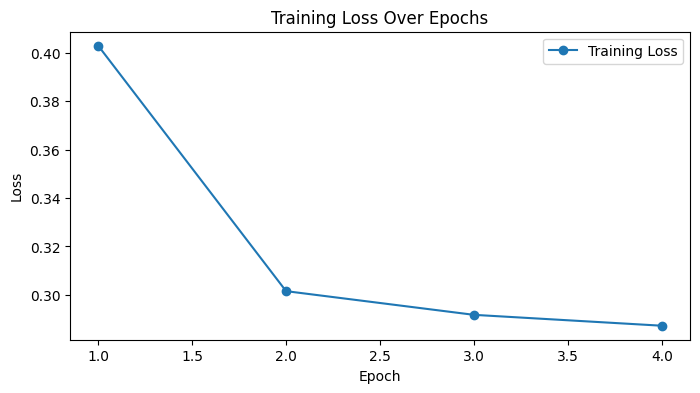

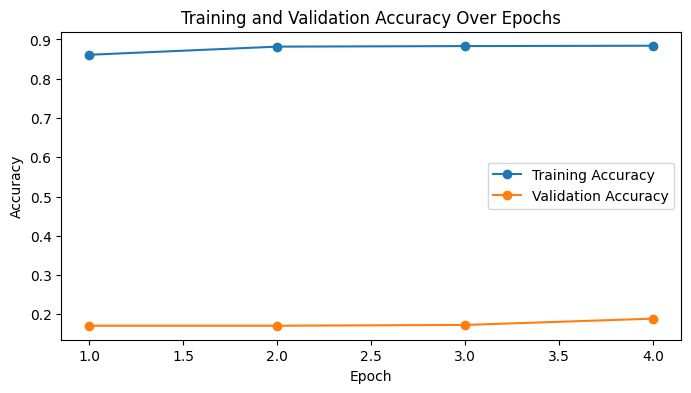

In [ ]:
train_losses = [0.4030, 0.3015, 0.2917, 0.2872]
train_accuracies = [0.8611, 0.8818, 0.8832, 0.8841]
validation_accuracies = [0.171, 0.171, 0.173, 0.189]

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Step 4.5: Testing/ Evaluation

In [ ]:
# Testing the model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
  for batch in tqdm(test_loader, desc = 'Testing'):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    logits = model(input_ids, attention_mask = attention_mask)
    y_pred.extend(torch.sigmoid(logits).cpu().numpy())
    y_true.extend(labels.cpu().numpy())


Testing: 100%|██████████| 250/250 [01:36<00:00,  2.59it/s]


### Step 4.6: Result reports

In [ ]:
# Convert predictions to binary format
pred_binary = (np.array(y_pred) > 0.5).astype(int)

# Evaluate accuracy and confusion matrix
accuracy = accuracy_score(y_true, pred_binary)
precision = precision_score(y_true, pred_binary, average = 'micro')
recall = recall_score(y_true, pred_binary, average = 'micro')
f1 = f1_score(y_true, pred_binary, average = 'micro')
class_names = [str(class_name) for class_name in mlb.classes_]
classification_report_result = classification_report(y_true, pred_binary, target_names = class_names)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_report_result}')
print(f'Precision:{precision}')
print(f'Recall:{recall}')
print(f'F1 score:{f1}')

Accuracy: 0.163
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        76
           1       0.76      0.11      0.19       234
           2       0.00      0.00      0.00       196
           3       0.43      0.69      0.53       394
           4       0.00      0.00      0.00       188
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00       106
           7       0.00      0.00      0.00        43
           8       0.00      0.00      0.00        32
           9       0.00      0.00      0.00       155

   micro avg       0.45      0.21      0.28      1435
   macro avg       0.12      0.08      0.07      1435
weighted avg       0.24      0.21      0.18      1435
 samples avg       0.30      0.22      0.25      1435

Precision:0.4452773613193403
Recall:0.2069686411149826
F1 score:0.28258801141769746


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Step 4.7: Inference

Sample inference

In [ ]:
def get_labels(text):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', truncation = True, padding = True, max_length = maxi_length)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask = attention_mask)
        probabilities = torch.sigmoid(logits)
        predictions = (probabilities > 0.5).int().cpu().numpy()[0]
    print(predictions)
    final_predictions = []
    for i in range(len(predictions)):
      if predictions[i] == 1:
        final_predictions.append(i)
    return final_predictions


text_input = "Under the General Tax Code as worded until 31 December 1978 the applicant company was liable to value-added tax (VAT) on its commercial activity. It paid a total of 291,816 French francs (FRF) in VAT on its 1978 transactions.", "10. Article 13-B-a of the Sixth Directive of the Council of the European Communities dated 17 May 1977 granted an exemption from VAT for “insurance and reinsurance transactions, including related services performed by insurance brokers and insurance agents”. That provision was to come into force on 1 January 1978.", "11. On 30 June 1978 the Ninth Directive of the Council of the European Communities dated 26 June 1978 was notified to the French State. It granted France an extension of time – until 1 January 1979 – in which to implement the provisions of Article 13-B-a of the Sixth Directive of 1977. Since such directives have no retroactive effect, the Sixth Directive ought nonetheless to have been applied from 1 January to 30 June 1978.", "12. Relying on the Sixth Directive, the applicant company sought reimbursement of the VAT it had paid for the period from 1 January to 31 December 1978, which it considered had not been due as the Ninth Directive had no retroactive effect. It also brought an action in damages against the State for failing to bring French law into line with the Sixth Directive within the prescribed period, thereby causing it to sustain damage equal to the amount of the VAT paid. It claimed reimbursement of the VAT paid or, failing that, the amount attributable to the period from 1 January 1978 to the date the Sixth Directive had come into force.", "13. The Paris Administrative Court dismissed its claims in a judgment of 8 July 1982. It held, inter alia, that it was clear from the Treaty of the European Communities that while directives placed an obligation on States to achieve a particular result, the choice of the appropriate means of implementing a directive in domestic law lay within the sole discretion of the national authorities, such that individuals and private bodies could not rely directly on a directive to defeat a provision of domestic law."
predicted_labels = get_labels(text_input)
print("Predicted Labels:", predicted_labels)

Predicted Labels: [array([2])]


## Step 4.8: Save the model

In [ ]:
# Save model and optimizer state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, '/content/drive/My Drive/saved_model.pth')

# Load
# checkpoint = torch.load('saved_model.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Step 5: Conclusion

The model achieved satisfactory performance on the validation and test sets, giving nearly similar performance as given in benchmarks on huggingface demonstrating its ability to classify legal texts into the relevant violated articles of the ECHR.